# AI演習（予測編）
「第2回」ver.2022/6/7

## 1.分類問題

分類問題とは、データがどのクラス（カテゴリ）に属するかを予測する問題です。  

たとえば、健康診断で得られたバイタルデータを使用して、その人が「健康であるか（健康クラス）」「病気であるか（病気クラス）」のどちらに属するかを分類するようなタスクが相当します。

### 1.1 ストーリー

あなたはZ社の人事担当者です。

従業員の離職は高くつき、損害も大きいです。
そして、能力のある優秀な従業員を引き留めることは、コストの抑制のみならず、競争優位を維持し、知的資本を守るうえでも役に立ちます。

さて、どうやって退職者を事前に予測しましょうか？（そして、早めの引き止め工作をしましょうか…？）


#### 使用するデータ
今回の章では、1000名の社員データから、退職しそうな社員を予測する「退職予測AIモデル」を作成します。

* 1000名の社員に対して、年齢や部署、査定ランクなど**全28項目**のデータが収集されています。


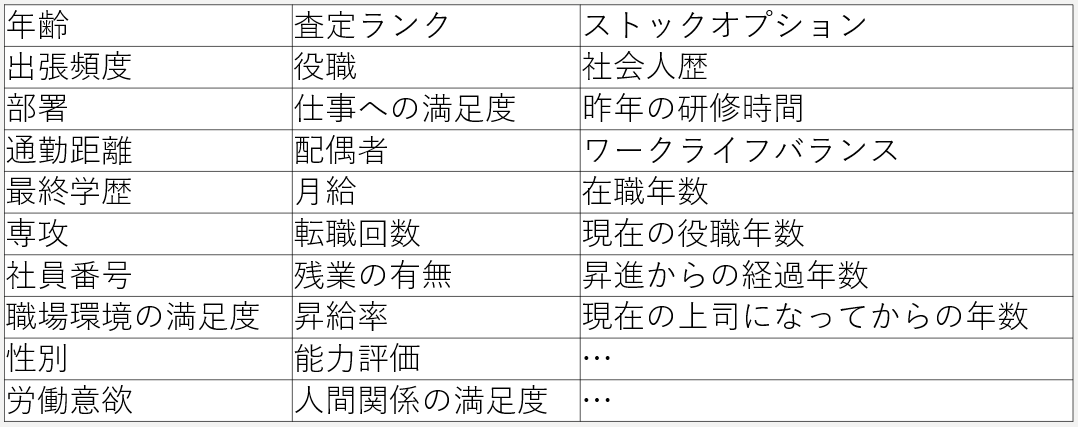

* **補足**：なお、このデータは本物ではなく、IBMのデータサイエンティストが、トレーニング用に作成してくれたものです（今回の演習にあたって、カラム名を日本語化してあります）
* **参照**：[IBM HR Analytics Employee Attrition & Performance | Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

### 1.2 ライブラリの準備

Pythonでの分析を始める前に、必要となるライブラリのインストールを行いましょう。

Google Colaboratoryには、AIの演習に必要な多くのライブラリが、最初からインストールされているのですが、中には自身でインストールする必要があるライブラリもあります。例えば、

* 新しすぎるライブラリ（まだ、それほど普及していない）
* ローカル言語のライブラリ（日本語対応など、ほぼない）


#### インストール

今回は演習の中で、データをグラフで可視化します。その際、通常であれば、matplotlibというライブラリを使用しますが、このライブラリは初期状態だと残念ながら日本語に対応していません（無理やり対応させる方法はいくつかありますが）

そのため、グラフの中で日本語（全角文字）を表示しようとすると、□（白い四角形・通称：とうふ）に文字化けしてしまうのです。

そこで、今回は日本語に対応しているmatpotlib（その名も、japanize_matplotlib）を、自身でインストールしてから、演習に望みたいと思います。

In [ ]:
# 日本語が使用可能なグラフ描画ライブラリをインストールする
! pip install japanize_matplotlib

補足：進捗を表すプログレスバーが表示された後、数行のインストールメッセージが表示されます。インターネット回線に不具合がなければ、10秒程度で完了します。

#### 日本語の文字化け（□□□）を訂正する（おまじない）

さて、通常のmatplotlibであれば、上の通り「japanize_matplotlib」のインストールで済むのですが、今回は演習の中で「決定木」と呼ばれる少し特殊なグラフを描画します。その際、日本語が文字化けしないように、さらに以下のような準備を行っておきましょう。

In [ ]:
# 日本語フォントをダウンロードする
! apt-get -y install fonts-ipafont-gothic

# フォントのキャッシュを削除する
# 削除すべきキャッシュのファイル名は、Matplotlibがバージョンアップすると変わるため、
# 下記のrmでうまく行かない場合、! ls -ll /root/.cache/matplotlib/ でファイル名を確認
# 旧ファイル名：! rm /root/.cache/matplotlib/fontList.json
# 旧ファイル名：! rm /root/.cache/matplotlib/fontlist-v300.json
! rm /root/.cache/matplotlib/fontlist-v310.json   # 2019/10/31段階でのファイル名

#### ランタイムの再起動（おまじない）

日本語フォントを反映させるため、このタイミングでランタイムを再起動します。

**再起動の方法：Google Colabratoryの上部メニュー → ランタイム → ランタイムを再起動 → はい**　　

ランタイムが再起動してから、次のセルを実行してください

In [ ]:
# 日本語フォントの設定
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

#### インポート

プログラムで使用するライブラリをインポートします。  

In [ ]:
# 数値解析・データ分析用ライブラリをインポートする
import numpy as np
import pandas as pd

# グラフ描画用ライブラリをインポートする
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import cv2

# 基本統計量を計算するためのライブラリをインポートする
import statistics

# matplotlib の出力をノートブック上に描画するための設定
%matplotlib inline 
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set_palette('husl')
pd.set_option("display.max_rows", 1000)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# # 不要な警告表示を消す
# import warnings
# warnings.filterwarnings('ignore')

### 1.3 データの確認
それでは、Z社の社員データを読み込みましょう。pandasライブラリに備わっているメソッドを利用すると、外部ファイルの読み込みや書き込みが簡単に行えます。


#### データのダウンロード

まず準備として、Google Colabratory上でファイルの読み込みを行うために、演習用サーバから必要なファイルをダウンロードします。次のセルを実行してください。

In [ ]:
# 演習用データ(csv形式)のダウンロード
! wget https://nai-lab.com/datasets/lesson/csv/人事情報.csv

演習用ファイルが、各自のGoogle Colaboratoryにダウンロードできたかを、以下の手順で確認します。

Google Colaboratoryの左側メニューから`[ファイル]`のアイコン（下図の赤丸部分）をクリックします。

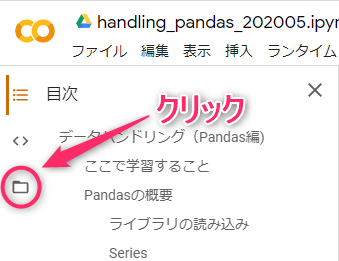

Google Colaboratory上のファイル一覧が表示されます。

ここに演習用ファイル `人事情報.csv` が存在すれば成功です。  

#### データ読み込み
ダウンロードしたデータを、Pythonの変数（データフレームという種類の変数を使っています）に格納して、最初の5件を表示してみます。

In [ ]:
# 学習用データの読み込み
df_employee = pd.read_csv('/content/人事情報.csv')
df_employee.head()

ちなみに、`head()` のカッコ内に数値を入力すると、表示する件数を指定することができます。

※ `(100)` なら、冒頭から100件を表示します。

In [ ]:
# 冒頭の10件を表示
df_employee.head(10)

**重要**：一番左側の「Yes」か「No」が入っている列が、退職の有無を表しています。この「Yes」か「No」を、機械学習には教えずに（隠した状態で）予測させて、それがどれだけ良い精度で予測できるかが、機械学習（AI）に求められる性能です。

#### データフレームの行・列数の確認
`shape` というメソッド（機能）を使うと、変数（データフレーム）に格納されているデータの、行数（件数）と、列数（項目数）が確認できます。

In [ ]:
df_employee.shape

- データは1000行、29列のデータであることがわかります。

#### データ型の確認
データをサラッと見ただけだと、「整数型だと思っていたら実は小数型だった」といった思い違いが発生することがあります。この手の誤解は、分析時に思わぬ不具合を引き起こすことがありますので、念の為に各列（項目）のデータがどんな型なのかを、`dtypes`というメソッド（機能）で調べてみます。

In [ ]:
df_employee.dtypes.to_frame()

変数は**int64型**（整数）か、**object型**（少し特殊な型。一般的には文字が格納されていることが多い）の、どちらかであることが分かりました。もし小数型がある場合は、floatと表示されますが、今回のデータには小数型はないようです。

- データ型についての公式ドキュメント：https://docs.python.org/ja/3/library/stdtypes.html

#### 欠損値の処理
欠損値とは何らかの理由で値が欠損していることです。理由は様々ですが、例えばアンケート調査で空欄のままになっている項目などに発生します。欠損値を無視して学習を進めてしまうと、モデルの精度低下を引き起こす恐れがありますので、欠損値に適切な対処を施すことが重要になります。

まずは、データの中に欠損値がないかを、`isnull`というメソッド（機能）を使って調べてみましょう。

In [ ]:
df_employee.isnull().sum().to_frame()

**注釈**：幸いなことに、どの項目にも欠損値は含まれていませんでした。

#### グラフで可視化
グラフを使って可視化することで、データに対して、よりイメージが湧きやすくなります。ここでは予測対象となる「退職」の列を、棒グラフで表してみましょう。



In [ ]:
# seabornのcountplotを用いて棒グラフで可視化
sns.countplot(x='退職', data=df_employee) # xに列名を指定する
plt.show()

**補足**：たった2行で、あっという間に棒グラフが完成しました。この手軽さもPythonの魅力です。とはいえ、ちょっと味気ないグラフなので、少しだけ装飾してみましょう。

In [ ]:
# seabornのcountplotを用いて棒グラフで可視化
sns.countplot(x='退職', data=df_employee) # xに列名を指定する
plt.title('退職者/雇用者')
plt.ylabel('人')
plt.xticks([0,1], ['退職者', '雇用者'])
plt.show()

**注釈**：退職者が200名弱に対して、雇用者（退職していない人）が800名ほどいることが、グラフで確認できました。数値を見るだけではイメージが湧きにくい場合は、こうしてグラフで可視化して確認することも有効です。

#### 数値以外の列を確認

機械学習による学習・予測に用いるデータは、原則として数値である必要があります（仮に文字だとしても、何らかの方法で数値化します）

前にデータ型を確認したところ、今回のデータでは以下の列が数値（int64）ではなく、文字（object）が格納されていました。

* 出張頻度
* 部署
* 専攻
* 性別
* 役職
* 配偶者
* 残業の有無

#### 値の出現頻度を確認
まずは、それぞれの列にどのような値が格納されているのかを、`value_counts()`というメソッド（機能）を使って確認してみましょう。

In [ ]:
# 出張頻度の値（と個数）を調べる
df_employee['出張頻度'].value_counts()

In [ ]:
# 部署の値（と個数）を調べる
df_employee['部署'].value_counts()

In [ ]:
# 専攻の値（と個数）を調べる
df_employee['専攻'].value_counts()

#### 演習①：列の値を調べる
以下のプログラムの空欄を埋めて、「性別」「役職」「配偶者」「残業の有無」の各列に存在する値と、それぞれの個数を出力するプログラムを完成させましょう。

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 性別の値（と個数）を調べる
df_employee[■空欄■].value_counts()

######################################################

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 役職の値（と個数）を調べる
df_employee[■空欄■].value_counts()

######################################################

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 配偶者の値（と個数）を調べる
df_employee['配偶者'].■空欄■

######################################################

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 残業の値（と個数）を調べる
df_employee['残業の有無'].■空欄■

######################################################

---
#### 演習②：説明変数の考察
ここまでの演習で、退職予測に使用するデータセットを、ざっくりと俯瞰しました。振り返りになりますが、以下の28項目をもとに、「退職しそうな人」と「退職しなさそうな人」を予想するのが、この後に続くミッションです。

* 年齢	
* 出張頻度	
* 部署	
* 通勤距離	
* 最終学歴	
* 専攻	
* 社員番号	
* 職場環境の満足度	
* 性別	
* 労働意欲	
* 査定ランク	
* 役職	
* 仕事への満足度	
* 配偶者	
* 月給	
* 転職回数	
* 残業の有無	
* 昇給率	
* 能力評価	
* 人間関係の満足度
* ストックオプション	
* 社会人歴	
* 昨年の研修時間	
* ワークライフバランス	
* 在職年数	
* 現在の役職年数	
* 昇進からの経過年数	
* 現在の上司になってからの年数


さて、これらの項目（説明変数）の中で、あなたは、どの要素が「退職」に関係がある（強い）と思いますか？ その理由も併せてお答えください。


### 1.4 前処理
データの前処理とは、データを機械学習モデルに学習させる前に行う処理のことで、料理で例えるならば具材の「下ごしらえ」です。下ごしらえの良し悪しで料理の味（分析結果）も劇的に変化します。

データ分析の分野では「前処理が8割」という言葉をよく見かけます。実際に分析をやり始めるとこの言葉の通り「欠損値をどう埋めるか？」「他の説明変数（特徴量）を生成した方がいいのでは？」など、ほとんどの時間を前処理に費やすことになります。

前処理には様々な手順・工夫・テクニックが存在するのですが、ここではチュートリアルとして、以下のような手順を一緒に行ってみましょう。

* 説明変数（特徴量）の選択
* カテゴリ変数の変換
* 目的変数の準備

#### 説明変数（特徴量）の選択

今回は、全28項目のデータが存在します。本来なら、この項目をすべて吟味して、然るべき前処理を行います。

しかし、今回は初学者向けのチュートリアル的な位置づけの演習ですので、問題をシンプルにするために、28項目の中から、**退職に関係が強そうな以下の10項目だけをピックアップ**して、学習と予測に使おうと思います。

* 年齢	
* 職場環境の満足度	
* 性別	
* 労働意欲	
* 仕事への満足度	
* 月給	
* 転職回数	
* 残業の有無	
* 人間関係の満足度
* 現在の上司になってからの年数


データフレームの`loc`というメソッド（機能）を使って、先程の10項目だけの新しいデータフレーム（名前は`df_x`）を作成します。

In [ ]:
# 10項目を選択して新しいデータフレーム（df_x）を作成する
df_x = df_employee.loc[:,['年齢', '職場環境の満足度', '性別', '労働意欲', '仕事への満足度', '月給', '転職回数', '残業の有無', '人間関係の満足度', '現在の上司になってからの年数']]
df_x.head() # 冒頭の5件を確認

列名（カラム名）が少し長い（「職場環境の満足度」など）ので、少し短くした新しい列名を付けておきます。（別に長くても良いのですが、これは好みの問題です。後々、視認性に影響してくる…ような気がするので）

In [ ]:
df_x.columns = ['年齢', '環境満足度', '性別', '労働意欲', '仕事満足度', '月給', '転職', '残業', '人間満足度', '上司年数']
df_x.head() # 冒頭の5件を確認

次に、列の並びが少し分かりにくいので、関係が強そうな列を近くに配置するように、並び替えてみます。並び替えには、データフレームの `reindex` というメソッド（機能）を使用します。

In [ ]:
# 見やすいように列の順番を並び替える
df_x.reindex(columns=['年齢', '性別', '転職', '月給', '残業', '労働意欲', '上司年数', '人間満足度', '環境満足度', '仕事満足度' ])
df_x.head() # 冒頭の5件を確認

これで、`df_x` という名前の変数（データフレーム）に、10個の**説明変数** を準備できました。ところで、なぜ、`df_x`という変数名にしたのでしょうか？ dfは「**D**ata**F**rame」の略です。そして、**x**は…　以前の講義であった、以下の内容を思い出してみましょう。

**復習：** データは上記のように「入力（問題）」と「結果（正解）」の2つの要素構成されています。機械学習（や数学）では特にこれらを、以下のように呼ぶことが多いので、覚えておきましょう。
* 入力（問題）→「**説明変数**」（プログラムでは変数名にxを付けることが多い）
* 結果（正解）→「**目的変数**」（プログラムでは変数名にyを付けることが多い）

目的変数（今回は「退職」の列）については、もう少し後のセクションで準備しましょう。その時は、この法則にならって、 `df_y` というデータフレーム名にしようと思います。

#### カテゴリ変数の変換
性別(男=Male,女=Female)や、血液型(A,B,O,AB)などは**カテゴリ変数**と呼ばれます。機械学習に使用するためには、これらを数値化しなければ精度の低下を引き起こすので、変換を行います。

ここでは、One-Hotという表現方法で、カテゴリ変数を変換する練習を行います。

One-Hot表現に変換するには、`get_dummies`というメソッド（機能）を使います。

In [ ]:
# 「性別」の列をOne-Hot表現に変換する(多重共線性を回避)
df_x = pd.get_dummies(df_x, columns=['性別'], drop_first=True)
df_x.head()

**注釈**：「性別」という列がなくなり、代わりに「性別_Male」という列が追加されました。この列は「Male(男性）は1で、女性は0」という**One-Hot**な表現になっています。


#### 演習③：One-Hot表現に変換する
以下のプログラムの空欄を埋めて、「残業」の列に存在する値（Yes、No）を、One-Hotな表現に変換しましょう。

**ヒント**：先ほどの「性別」のときと同じ要領です。

In [ ]:
# ##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 「残業」の列をOne-Hot表現に変換する
df_x = pd.■空欄■(df_x, columns=[■空欄■], drop_first=True)
df_x.head()

# ######################################################

**確認**：上のプログラムが成功すると、「残業」の列がなくなり、代わりに「**残業_Yes**」という列が新しく追加されます。「残業_Yes」は、以下のように、**1（残業あり）**、**0（残業なし）**のOne-Hotな表現になっていれば成功です。


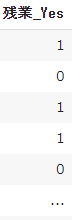

## 2.学習と予測

### 2.1 目標の設定

いざ分析を始める前に、目標を設定することはとても重要です。闇雲に分析をして結果を出しても意味はありません。ビジネス上の意義や、実社会での利用用途を考えて、理想的かつ現実的な目標を定める必要があります。

なお、ここでいう目標とは分析の結果**「説明変数」から、どのくらいの精度で「目的変数」を予測できたか？**ということになります。今回のケースなら、「人事情報から」「退職する人を」「どのくらい予測できたか？」となりますね。


#### 目的変数の準備

上のセクションで、説明変数（df_x）が用意できました。次は肝心要の**目的変数**（予測対象）を格納したデータフレーム（名前は、法則にならって `df_y` としましょう）を準備します。

今回の目的変数（予測したい列のことですよ！）は「退職」ですので、退職の列だけを抽出して、`df_y`を作成します。

In [ ]:
# 列名を選択して新しいデータフレーム（df_y）を作成する
df_y = df_employee.loc[:,['退職']]
df_y.head()

#### 目標設定
まず、予測すべき「退職」列を、`value_counts` というメソッド（機能）を使って、調べてみましょう。

In [ ]:
# 退職の値（と個数）を調べる
df_y.value_counts()

**注釈**：1000名の社員のうち、833名の雇用者（退職していない）の人と、167名の退職者がデータ内に存在することが分かりました。まずは現実的に、167名の退職者のうち**仮に半分も事前に察知できたなら及第点**ということとして、**167×50%**＝**84名**の退職者を予測できるAIモデルを作成することを、最初の目標を設定することにしましょう。



### 2.2 データの分割


#### 訓練用と検証用

現在、1000件のデータを2個のデータフレーム（`df_employee_x` と `df_employee_y`）に格納しています。  

* `df_employee_x`：10種類の説明変数（1000件）
* `df_employee_y`：退職の「Yes/No」（1000件）



これを今後の目的に合わせて、さらに2種類（合計4個）のデータに分割します。

* `train_x`：AI（モデル）を「訓練」するためのデータ（説明変数）
* `train_y`：AI（モデル）を「訓練」するためのデータ（目的変数）
* `valid_x`：AI（モデル）の精度を「検証」するためのデータ（説明変数）
* `valid_y`：AI（モデル）の精度を「検証」するためのデータ（目的変数）

学校に例えると、「**訓練**」は授業で行う「練習問題」に相当します。練習問題をたくさん解くことで、モデルは賢くなります。 よくAIの分野では「学習」という言葉を耳にしますが、ここでは「学習」と「訓練」は同じ意味で使っています。




そして、どの程度賢くなったかを確認するが「**検証**」で、これは「模擬試験」に相当します。いくら練習問題で高得点を叩き出しても、それは答えを覚えてしまっているダケかもしれませんよね？ですからこの検証用のデータは、AI（モデル）の訓練（学習）には使わずに、隠しておきます（学校の模擬試験も、最初からどんな問題が出題されるか分かってしまったら、真の実力を測ることはできません。それと同じです）

さらに実務では、この「検証」である程度よい成績を収めたモデルを使用して「本試験」…つまり未知である値を実際に予測させて、実運用に耐えうる精度かどうかをテストするという流れになります。


In [ ]:
# データを分割するライブラリを読み込む（おまじない）
from sklearn.model_selection import train_test_split

データを「訓練用」と「検証用」に分割するには、`train_test_split` というメソッド（機能）を使用します。

In [ ]:
# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_x, df_y, train_size=0.7, random_state=0, stratify=df_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

print(
    '訓練データ:',
    train_x.shape,
    train_y.shape,

    '検証データ:',
    valid_x.shape,
    valid_y.shape
)

**注釈：** 1000件のデータを、訓練用データ700件と、検証用データ300件に分割しました。この割合は、train_test_split関数の`train_size`パラメータで変更できます。今回は`train_size`=**0.7**を指定しましたので、訓練用データを70%、検証用データを30%の割合で分割されました。

この割合に決まった値はありませんが、一般的には**7:3**や**8:2**、**6:4**にすることが多いようです。

#### 分割後の説明変数

ここで、分割した後の訓練用データ（の説明変数） `train_x` の中身を見てみましょう。

In [ ]:
# 訓練データの説明変数を確認
train_x.head()

**注釈：** 一番左側の**太字の番号**（これをインデックス番号と呼びます）に注目してください。先ほどまではキレイに整列していた左側のインデックス番号が、バラバラになっていることが分かります。訓練データと検証データに偏りが生じることを避けるため、`train_test_split`関数によりシャッフルされたのです。

#### 分割後の目的変数

同様に、分割した後の訓練用データ（の目的変数） `train_x` の中身を見てみましょう。

In [ ]:
# 訓練データの目的変数を確認
train_y

**注釈**：やはり、左側のインデックス番号がバラバラにシャッフルされていることが確認できます。


ここで、訓練用データと検証用データとで、目的変数のYes,Noの割合に、大きく偏りがないかを確認します。

なぜこんな確認をするかと言うと、`train_test_split`メソッドで分割した際に、例えば訓練用データにばかり退職者（Yes）の人が集まってしまい、検証用データには退職者（Yes）の人がほとんどいないような、**不均衡なデータ**で分割されてしまったら、いかがですか？

これでは訓練も検証もあまりよい精度が期待できません。ですから、**バランスよくYesとNoが振り分けられている**ことが望ましいわけです。

In [ ]:
# 訓練用データ（の目的変数）の偏りを確認する
np.unique(train_y, return_counts=True)

In [ ]:
# 検証用データ（の目的変数）の偏りを確認する
np.unique(valid_y, return_counts=True)

### 2.3 AIモデルの訓練

ここまででデータの前処理が（一応）完了しました。データの前処理は、この後に続くモデルの精度を左右する重要な作業のため、突き詰めると、まだまだいろいろできそうですが、きりがないので、まずはこの程度で、AIモデルを訓練して検証してみたいと思います。  

AIモデルを訓練するための手法には以下のような様々なアルゴリズムがあります（これでもほんの一部です）

1. ロジスティック回帰
2. **決定木**
3. ランダムフォレスト
4. XGBoost
5. LightGBM
6. Neural Network

まずは、機械学習の「教師あり学習」ののうち、初学者にも理解がしやすい「**決定木**」の手法から試してみましょう。

#### 決定木（分類木）

決定木とは、**「不純度」を表すジニ係数を使用して分類していくモデル**です。…という説明で理解できる人の方が少ないと思いますので、ここからじっくりと解説していきます（ご安心ください）

今回は決定木を使って分類をするので、分類木とも呼ばれる手法になります。この手法は、分類していく様を可視化できるという強みがありますので、まずは実際に分類・可視化してから、理論を追いかけて見ましょう。

In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

#### ハイパーパラメータの設定

機械学習でどのように学習をするのかについて、**あらかじめ人間が設定しておく値**を総称して「**ハイパーパラメータ**」と呼びます。

今回の決定木では、**木の深さ**というハイパーパラメータを手動で設定します。（それ以外にも、ハイパーパラメータは多数存在するのですが、まずは感覚的に理解しやすい**木の深さ**を例にしましょう）

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

#### 決定木による学習

いよいよ、機械学習の「学習」を行いましょう。といっても、たった一行で終わってしまうので、拍子抜けしてしまうかもしれませんね）

`fit`というメソッド（機能）に、訓練用データ（の説明変数と目的変数）を渡してあげると、学習が始まります。このとき巨大なデータ（画像や動画などは特に）の場合は、学習に数秒～数分～数時間かかることもありますが、今回は700件の数値データですので一瞬で学習が完了します。

In [ ]:
# 学習
dt.fit(train_x, train_y)

**注釈：** 学習が完了すると、学習に使用したハイパーパラメータの一覧が表示されます。この段階ですべてを理解する必要はありませんが、よく見ると、先ほど手動で設定した**木の深さ=2**が`max_depth=2`と正しく設定されていることが確認できます。


#### 決定木の可視化

それでは、決定木モデルが、700件の訓練用データを使った学習を経て、どのような判断で退職者の特徴を捉えたのかを、木を可視化することで確認しましょう。

In [ ]:
# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

**注釈**：実行すると、何やら「Yes、No」チャートのような図が出てきました。これが学習の結果、決定木モデルが退職者と雇用中の人を見分けるために得たルールなのです。

上記の図には少し分かりにくい専門用語も含まれていますので、日本語の注釈を付けたのが以下の画像になります。なお、この図を逆さまにすると、まるで木のような形をしていることから、決定木と呼ばれています。そのため、一番上を木の根っこ（ルート）と表現することもあります。


**注釈**：それでは一番上の木の根っこ（ルート）から見ていくことにしましょう。この段階では、データ数（図中の`samples`）は**700人**です。図にある`value=[583, 117]`は、700人中、雇用中の人（退職No)の人が**583人**、退職済み（退職Yes）の人が**117人**であることを表しています。

そこから最初の指標、つまり一番重要であろう説明変数として決定木がはじき出したのは「**年齢**」でした。ここで**年齢が若い**の人は木の**左側**へ、**ベテラン**の人は木の**右側**に遷移することになります。



ここで、決定木の左側、つまり「若い人」のグループに注目します。ここには700名中、20名の社員が振り分けられました（`samples=20`）ほぼ新人といってもいいくらいの、かなりの若手グループですね。そして、次の振り分けの指標が`月給`です（やはり！）。月給が**小さい**（つまり安い）人は**左側**へ、大きい（つまり高い）人は**右側**へ遷移します。

さて、次に3段目に目を移します。

一番左下には、17名（`samples=17`）の社員が振り分けられています。この人たちは**「月給の安い、若い人」**です（せつない…）
退職者の割合を計算すると17名に対して退職済み15名ですから、15/17=**約88%**の退職率です（やばいですね！）

左から二番目には、3名（`samples=3`)の社員が振り分けられています。この人たちは**「月給が高い、若い人」**です。このグループはなんと誰も退職していません！（value=[3,0]の、0の部分）

#### 課題④：決定木の考察
ここまでの解説を参考に、**右側も含めた**決定木全体から読み取れることや、あなたが気付いたことを、レポートに自由に記入してください。

#### 演習⑤：木の深さの調整

以下のプログラムの空欄を埋めて、好きな深さ（3以上）で決定木を作りましょう。


In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

# ハイパーパラメータの設定（今回は木の深さを「3以上」に設定する）
dt = DecisionTreeClassifier(max_depth=■空欄■, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

#### 演習⑥：決定木の考察

上の演習で作成した決定木（深さ3以上）を見て、感じたこと思ったこと、そこから読み解けそうなことなどなど、なんでも自由に考察して記してください。


#### 決定木による予測



それではいよいよ700件の訓練用データで学習を行った決定木のモデルで、300件の検証用データについて、予測をしてみましょう。この段階で決定木のモデルは、300件の検証用データの答え（Yes、No）は知りません。さてさて、どのくらい当てることができるのでしょうか…！

In [ ]:
# 次の演習のために木の深さ2で、再度学習をしなおしておく
dt = DecisionTreeClassifier(max_depth=2, random_state=0)
dt.fit(train_x, train_y)

# 予測
dt_pred = dt.predict(valid_x)

**注釈**：予測は`predict`というメソッド（機能）を使って行います。が、これ（上記のセル）を実行しても何も応答はありません。しかし、決定木の予測した回答は、`dt_pred`という変数の中にすでに格納されています。では、その`dt_pred`の中身を確認してみましょう。

In [ ]:
# 予測
print('決定木の予測（全300件）：\n{}'.format(dt_pred[0:-1]))

**注釈**：でました！これが**正解を教えていない**検証用データに対して、決定木が予測した回答（Yes、No）が上記です。パッと見たところ、`No`が多く、ときどき`Yes`がある感じでしょうか…。ここから、この予想がどのくらい当たっていたのかを検証していきましょう。


#### 精度評価

このセクションでは、機械学習モデル（今回は決定木）の予測精度を測定します。まずは、予測結果と実際の退職結果（正解）を見比べてみましょう。

In [ ]:
# 予測結果と正解の比較
print('決定木での予測（先頭10件のみ）：{}'.format(dt_pred[0:10]))
print('実際の退職結果（先頭10件のみ）：{}'.format(np.array(valid_y[0:10])))

**注釈：** 予測と正解を見比べてみてどうでしょう。最初の10件だけでは精度の判断がしにくいですので、検証データ(今回は300件）のすべてに対して、精度（正解率）を測定してみましょう。

`accuracy_score`というメソッド（機能）を使うと、正解率を簡単に算出することができます。

In [ ]:
y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

from sklearn.metrics import accuracy_score  # ライブラリのインポート（おまじない）
print(accuracy_score(y_true, y_pred)) # 正解率を測定する

**注釈**：精度を測定したところ、なんと**約82.3%**という高い正解率を叩き出すことができました！（やりました！）

#### 正解率の罠

しかし、ここで少しストップ！**一度立ち止まりましょう**。経験上、最初からこんなに良い精度が出てしまうのは少し**怪しい**匂いがします。ここで今一度、先程の予測結果と正解の比較を再掲載します。

In [ ]:
# 予測結果と正解の比較
print('決定木での予測（先頭10件のみ）：{}'.format(dt_pred[0:10]))
print('実際の退職結果（先頭10件のみ）：{}'.format(np.array(valid_y[0:10])))

**注釈**：1行目の決定木での予測をよーく見てみましょう。**すべてがNo**になっています。決定木では、最初の10名に対して全員が「No（退職しない）」と予測しています。この辺で少し嫌な予感がするのですが、決定木での予測を、もう一度、全件見直してみます。

In [ ]:
# 予測
print('決定木の予測（全300件）：\n{}'.format(dt_pred[0:-1]))

**注釈**：件数が多くなったので少し分かりにくいですが、Noに比べてYes（退職すると予測）が**圧倒的に少ないような感じ**がします。そんな「感じ」がしたら、きちんとデータを計測して裏取りをしましょう。

以下のように、`unique`メソッドで、NoとYesの件数を測定します。

In [ ]:
np.unique(dt_pred, return_counts=True)

**注釈**：Noと予想したのが287件に対して、**Yesと予測したのがたったの13件**です。割合を計算すると、13/300=約**4.3%**という少なさです。これは何かマズイことが起きている気がします。

そもそも、元のデータは1000名中、167名の退職者がいましたので、実際は167/1000=**16.7%**ほどの退職率でした。それなのに、決定木が「離職する」と予想したのは、たった**4.3%**だけ…けれども、正解率を測定すると約**82.3%**のハイスコア…これはいったいどういうことなのでしょうか？

**重要**：そこには、精度評価の指標として「正解率」を使った場合の危険が隠されています。そもそも、事実として約17%の退職者がいたということは、退職していない（雇用中）人は全体の83%になります。

このとき、AIが何も考えずに**「仕事を辞める人はいない！全員、退職はしない！」**と超強気の予想（？）をしたとしましょう。つまり予想は100%が「No」という状態です。こんな無茶苦茶な予想（？）であっても、83%はもともと退職していないワケですから、**正解率はなんと83%**になってしまうワケです（そんなズルイ！）

言われてみれば当たり前なのですが、このようなミスを結構、やってしまうことがあります。精度評価の指標として「正解率」だけを追い求める危険性をおわかりいただけたでしょうか？

## 3.評価とチューニング

### 3.1 様々な評価指標

#### 再現率

このように、YesとNoのバランスが悪いデータを**不均衡データ**と呼びます。不均衡データで予測する場合は、正解率だけですと前述のような怪しげな結果になりますので、別な精度評価の指標も組み合わせるのが一般的です。



ここでは「**再現率**（回収率とも呼ばれます）」という評価指標をご紹介します。今回のケースにおいて再現率は**「本当に退職した人の中から、AIが退職すると予想できた人の割合」**になります。つまり退職しなかった人は、この再現率では考慮する必要がありません。

冷静に考えると、今回は「退職者をいかに早期に発見するか」が重要でしたので、退職しなかった人は置いておいても、まずは退職した人に注目して、それをいかに見つけていくか（回収するか）が重要なわけです。そういう意味では前述の「正解率」よりも、この「再現率（回収率）」のほうが、今回使用する指標としては適切な気がしませんか？





それでは早速、今回の決定木の予想について、正解率ではなく「再現率」で、精度を測定してみましょう。

`recall_score`というメソッド（機能）を使うと、再現率を簡単に算出することができます。

In [ ]:
from sklearn.metrics import recall_score    # ライブラリのインポート（おまじない）
print(recall_score(y_true, y_pred))         # 再現率を測定する

注釈：0.1…？？？ということは、なんと、**再現率は10%**（ガガーン）

167名の退職者がいるとすると、なんとこの決定木ではそのうちの16～17名程度しか、見つけることができないことになります（これでは人事部の上司にめっちゃ怒られます！）

よくある「**AIに過度な期待を寄せたら、裏切られて、失望した**」というパターンになってしまいました。これを何とかする方法はあるのでしょうか？


ここまでは「正解率」と「再現率」という2つの評価指標で精度を測定しました。そして、

* 「正解率だけを追い求めるのであれば、すべてNo（退職しない）と予測すれば良い（それはズルイ）」
* だから「本当に退職した人の中から、AIが退職すると予想できた人の割合=再現率」も合わせて評価する必要がある。

と前回の講義で学びました。しかし、よく考えてみましょう。今度は逆に「**再現率を追い求めるのであれば、すべてYes（退職する）と予想すれば良い！**」ということになるような気がしませんか？

「このひとは、退職しそうです」「あのひとも退職しそうです」と、甘々な予想で、どれもこれも「退職しそうな人」として分類してしまったら、たしかに再現率は100%（！？）になるのですが、それにどんな意味があるのでしょうか？（そしてまた、人事部の上司に怒られるのは目に見えています）

そこでもう一つの評価指標の「適合率」の出番です。

#### 適合率

再現率と対をなす評価指標に「**適合率**」があります。混乱するので並べて紹介します。

* **正解率**は「AIの予想（退職のYes/No）が、実際の結果（Yes/No）と同じだった割合」でした。
* **再現率**は「本当に退職した人の中から、AIが退職すると予想できた人の割合」でした。
* **適合率**は「AIが退職すると予想した人の中で、実際に退職した人の割合」です。

どうでしょうか？（少し混乱すると思うので、じっくり読んで考えてください）



In [ ]:
# ライブラリのインポート（おまじない）
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する

**注釈**：この段階でのAIモデルの再現率、適合率は上記の通りでした。

* 再現率が**10%**ということは、もし100名の退職する人がいたら、そのうちの10名をAIが見つけられたということです。

* 適合率が**38%**ということは、AIが退職する人を100名選んだとしたら、そのうちの38名が実際に退職したということです。

**補足**：この適合率と再現率の2つの評価指標は「**片方を上げれば、片方が下がる**」ようなペアの関係になっています。ですから、ある程度以上になると、両方を同時に上げるような都合の良いことは出来ません。バランスを見ながら、適合率と再現率、そして正解率をどのアタリに着地させるかを、考えていきます。

#### 適合率と再現率の理解

適合率、再現率、正解率という評価指標が出揃ったところで、今回の目標を改めて設定しましょう。

まず、適合率、再現率のどちらを優先するべきなのか？という点を考えます。

ここでは仮に退職者が10名いる部署で、**適合率**の高いAIモデルと、**再現率**の高いAIモデルの、それぞれを導入することを考えてみましょう。あなたはこの部署の責任者で、退職者を引き止める役目を持っています（責任重大ですね）


#### **適合率**を重視する場合


まず、**適合率**の高いAIの場合、例えば、AIが辞めると予測した人は5人だけだったとします。ただこの5人は、本当に辞める10人が高い確率で含まれています（適合率が高いAIモデルなので）。あなたは**この5人を引き留めることに集中できる**かもしれませんが、残りの5人を洗い出せなかったことに、やや不満を覚えるかもしれませんね。

#### **再現率**を重視する場合

次に、**再現率**の高いAIを導入した場合を考えます。AIが辞めると予想したのは20人でした（再現率の高いAIモデルなので…先程よりも4倍も多いですね）。この20名の中には、当然、本当に辞める10名以外の人も含まれています。先ほどのように、**事前に何も手を打てずに退職されるケースは減る**一方で、一度に20人の部下を気にかけるのは難しく、手間がかかります。20人のなかには本当は辞める気のない人も含んでいるので、そういう部下を必要以上に気にかけることになるのは、時間の無駄になる可能性もあります（まあ、部下とのコミュニケーションという意味では、気にかけることは無駄にはならないと思いますが）

#### 演習⑦：適合率と再現率

あなたがもし、退職予測AIを利用する立場（引き止める側）だとしたら、適合率の高いAI製品と、再現率が高いAI製品のどちらを採用しますか？

* **適合率**が高いAI製品：
  * メリット：確実に辞めるであろう人に絞ってピックアップしてくれるため、提示された少人数の対象者の引き止めに注力できる。
  * デメリット：退職する人を見逃してしまう恐れがある。

* **再現率**が高いAI製品：
  * メリット：辞めるかどうか、やや微妙な人もピックアップしてくれるため、退職する人を見逃す可能性が低くなる。
  * デメリット：少しでも退職の可能性があればピックアップしてしまうため、対象者の人数が増えてしまい、引き止め対策に掛かる時間が増えてしまう。

現実的には、適合率と再現率のバランスが大事であることは重々承知の上で、上の2つの製品のうち、どちらかを選ぶ必要があるとしたら、どちらを選びますか？

その「理由」や、導入後の「運営方法」（そのAIの予想をどう使っていくか）なども含めて、考察してまとめてください。



#### F1値

再現率と適合率は**トレードオフ**になっているのです。どちらにもそれぞれの良さがあり、どちらが優れたモデルか決めることはできません。そこで、両者のバランスをとった**F1値**という指標があります。このF値が高ければ、バランスがよく性能が良いことを意味します。

* **F1値** = (2×適合率×再現率) ÷ (適合率＋再現率）

In [ ]:
from sklearn.metrics import f1_score

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

#### 目標の再設定

これらを踏まえて、改めて今回の目標を再設定しましょう。まず、そもそものデータとしては、1000名の社員の中で、167名の退職者がいました。割合では、167/1000名=**約16.7%**の退職率でした。

すでに実用化して市場に出ている**他社の退職予測AI**の性能をカタログでチェックすると、**「退職の予兆ありとAIが診断した人は、平均の倍以上退職していた」**という謳い文句がありました。

これは、適合率が平均の倍（今回のケースなら16.7%×2倍=約33%）ということを意味します。

そこで、当面の目標としては「**適合率33%以上をキープしつつ、再現率ができるだけ高い（F1値ができるだけ高い）モデルを構築する**」ことを目指したいと思います。

### 3.2 データの追加

予測の精度を上げるために、まず検討すべきことは「データを増やす」ということです。今回は当初、1000件のデータがあり、それを訓練用と検証用に分けて予測モデルを作成しました。

ここで、例えば追加のデータとして、Z社の人事部から、新たに500件のデータ提供があったとしましょう。この500件を追加して、合計1500件のデータで、もう一度、検証をしてみましょう。

#### 読み込みと前処理

In [ ]:
# 追加データ(csv形式)のダウンロード
! wget https://nai-lab.com/datasets/lesson/csv/人事情報（追加）.csv

# 追加データの読み込み
df_add = pd.read_csv('/content/人事情報（追加）.csv')

In [ ]:
# 追加データの件数を確認
df_add.shape

変数 df_add に、500件の追加データを格納できました。これを、もとからあった1000件と統合します。統合は、pandasのconcatメソッドを使用します。

In [ ]:
# 1000件のデータと500件のデータを統合する
df_employee_add = pd.concat([df_employee, df_add])
df_employee_add.shape

1500件のデータが確認できました。

続いて前処理を行います。ここはすでに説明した手順と同じですので、今回は一気に行います。

In [ ]:
# 10項目を選択して新しいデータフレーム（df_x）を作成する
df_x = df_employee_add.loc[:,['年齢', '職場環境の満足度', '性別', '労働意欲', '仕事への満足度', '月給', '転職回数', '残業の有無', '人間関係の満足度', '現在の上司になってからの年数']]

# カラム名（列名）を短くする
df_x.columns = ['年齢', '環境満足度', '性別', '労働意欲', '仕事満足度', '月給', '転職', '残業', '人間満足度', '上司年数']

# 見やすいように列の順番を並び替える
df_x.reindex(columns=['年齢', '性別', '転職', '月給', '残業', '労働意欲', '上司年数', '人間満足度', '環境満足度', '仕事満足度' ])

# 「性別」「残業」の列をOne-Hot表現に変換する(多重共線性を回避)
df_x = pd.get_dummies(df_x, columns=['性別'], drop_first=True)
df_x = pd.get_dummies(df_x, columns=['残業'], drop_first=True)

# 列名を選択して新しいデータフレーム（df_y）を作成する
df_y = df_employee_add.loc[:,['退職']]

# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_x, df_y, train_size=0.7, random_state=0, stratify=df_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

print(
    '訓練データ:',
    train_x.shape,
    train_y.shape,

    '検証データ:',
    valid_x.shape,
    valid_y.shape
)

1500件のデータを、7:3に分割しましたので、訓練用データが1050件、検証用データが450件となりました。


#### 決定木の学習と予測

追加データの準備が整いましたので、さきほどと同じく決定木を使って学習と予測を行います。

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

データを増やす前と比較します。

* 再現率：10%→15%に向上
* 適合率：38%→68%に向上
* Ｆ１値：15 →25 に向上

いずれの指標も向上しました！

（再現率が15%というのは、まだまだ低いとは思いますが、それでも少し良くなったのは朗報です）

### 3.3 不均衡データの扱い

さて、ここからは更に精度向上を目指して、考えられる限りの工夫を盛り込んでいきます。ここであらためて、そのデータのうち、雇用中と退職者の人数を確認します。



In [ ]:
# 訓練用データ（目的変数）の偏りを確認する
np.unique(train_y, return_counts=True)

In [ ]:
# 検証用データ（目的変数）の偏りを確認する
np.unique(valid_y, return_counts=True)

訓練用と検証用で、ほぼ同じ割合で分割できているハズです。

このとき（当たり前なのですが）**雇用中の人数に比べて、退職者の人数が圧倒的に少ない**ことが、気になります。

このようなバランスの悪いデータを「**不均衡データ**」と呼ぶのですが、このような不均衡データを使って、何らかのAIモデル（今回は決定木）を学習させる場合は、

* 多数派のデータを、少数派のデータに合わせる**アンダーサンプリング**
* 少数派のデータを、多数派のデータに合わせる**オーバーサンプリング**

というテクニックが用いられることがあります。





#### オーバーサンプリング

ここでは、オーバーサンプリングをして、**少数派（退職者）のデータを水増し**することで、訓練用データのバランスを調整してみましょう。

少数派のクラス（今回なら退職がYesの人たち）を、多数派のクラス（退職がNo）の件数の50%になるように、オーバーサンプリングで水増しを行います。

In [ ]:
# 訓練用データをオーバーサンプリング（水増し）する
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.5, random_state=0)
train_x_over, train_y_over = oversample.fit_resample(train_x, train_y)

In [ ]:
# 訓練用データ（目的変数）の偏りを確認する
np.unique(train_y_over, return_counts=True)

**注釈**：少数派（退職=Yes）のデータが、169件→440件に増えました。


#### 決定木の学習と予測

それではオーバーサンプリング後の訓練用データを使用して、モデルを学習させて、精度の検証を行います。

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x_over, train_y_over)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

オーバーサンプリング前と比較します。

* 再現率：15%→18%に向上
* 適合率：68%→56%に減少
* Ｆ１値：25 →27 に向上

適合率が減少して、再現率が向上しました。トータルで見るとF1値は向上していますので、さきほどよりはバランスのよいモデルになったと判断できます。

### 3.4 様々な機械学習の手法

決定木の精度を上回る精度を出すために、ここからは機械学習による分類問題でよく使われるメジャーな手法を2つ試してみます。今回は手法を変えることでどの程度、精度が向上（または低下）するのかを体験するのが趣旨です。そのため各手法の詳細なロジックについては省略しますが、手法の名称くらいは覚えておくと、役に立つと思います。

1. **決定木** ← ここまでに試した
2. **ランダムフォレスト** ← これから試そう
3. **LightGBM** ← これから試そう

なお、主要な機械学習手法の特徴を以下にまとめました、参考にしてください。

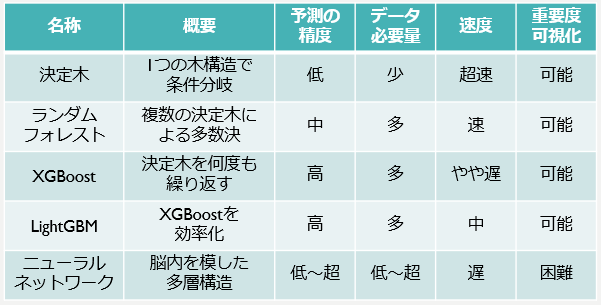

#### ランダムフォレスト

ランダムフォレストは、いままで使ってきた**決定木を、複数個**作って、それらで**多数決**を取って、最終的な予測判断をする手法です。

ランダムフォレストの**フォレストとは「森」や「林」**のことです。決定木が「木」でしたので、このランダムフォレストは、木が複数集まって「森」というわけですね（洒落たネーミングです） さて、「木」と「森」とでは、どちらの精度が上になるでしょうか？ さっそく試してみましょう。



In [ ]:
# ランダムフォレストに必要なライブラリを読み込む
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# 学習
rf.fit(train_x_over, train_y_over)

# 予測
rf_pred = rf.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(rf_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：ランダムフォレストで学習＆予測した結果…
* 再現率は決定木の 18% から **38%** に急上昇しました！
* 適合率は決定木の 56% から **56%** で変化ありませんでした
* Ｆ１値は決定木の 27 から **45** に急上昇しました！

これは「森」の効果はテキメンです。「木」よりも「森」、強し！？

ランダムフォレストは、決定木のような判断分岐の可視化は行なえませんが、その代わりに、予測の判断として何を重要視したのかを、グラフで可視化できます。さっそく確認してみましょう。

In [ ]:
# 重要度の抽出
feature_importances = pd.Series(rf.feature_importances_, index=train_x.columns).sort_values(ascending=True)
feature_importances = feature_importances.to_frame(name='重要度').sort_values(by='重要度', ascending=False)

# TOP20可視化
feature_importances[0:20].sort_values(by='重要度').plot.barh()
plt.legend(loc='lower right')
plt.show()

**注釈**：ランダムフォレストは「月給」「年齢」「上司年数」などを重要な指標として挙げました。決定木のときよりも「年齢」や「上司年数」の優先順位が高くなっていますね。


#### LightGBM

LightGBMも決定木を組み合わせた手法で、データ分析競技の上位ランカーたちも好んで使用する人気の手法です。

仕組みは、ランダムフォレストと少し違っていて、**決定木を何度も何度も繰り返す**ことで、精度を上げていきます。このとき、ただ単に繰り返すだけでなく、その**直前の決定木が間違えたところを中心に学習**させる「**ブースティング**」と呼ばれるテクニックを用いているのが特徴です。現実世界で言えば、試験の問題集を何周も解くときに、2回目は1回目で間違えた問題を、3回目は2回目で間違えた問題を中心に学習することで、徐々に弱点を減らしていこう…という学習方法に近いでしょうか。

このLightGBMもプログラム自体は（使うだけれあれば）それほど難しいことはなく、ここまでの決定木やランダムフォレストと同じ要領で使用することができます。さっそく試してみましょう。

In [ ]:
# LightGBMに必要なライブラリを読み込む
import lightgbm as lgb
gbm = lgb.LGBMClassifier(random_state=0)

# 学習
gbm.fit(train_x_over, train_y_over)

# 予測
gbm_pred = gbm.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(gbm_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：LightGBMで学習＆予測した結果…
* 再現率は決定木の 18%、ランダムフォレストの 38% から、**41%**に上昇しました！
* 適合率は決定木の 56%、ランダムフォレストの 56% から、**49%**に減少しました。
* Ｆ１値は決定木の27、ランダムフォレストの 45から、**45**で変化はありませんでした。

LightGBMではF1値は0.45をキープしたまま、適合率が下がって、再現率が上がりました。

これはまさに「適合率を優先するか？」「再現率を優先するか？」という状態にはなりますが、いずれも最初の決定木よりは随分と改善されました。

LightGBMでも重要視した説明変数を可視化することができますので、確認してみましょう。

In [ ]:
# 重要度の抽出
feature_importances = pd.Series(gbm.feature_importances_, index=train_x.columns).sort_values(ascending=True)
feature_importances = feature_importances.to_frame(name='重要度').sort_values(by='重要度', ascending=False)

# TOP20可視化
feature_importances[0:20].sort_values(by='重要度').plot.barh()
plt.legend(loc='lower right')
plt.show()

**注釈**：決定木やランダムフォレストと、似ている部分もあれば、違う部分もありますね。

「決定木」「ランダムフォレスト」「LightGBM」は、どれも同じ「木」という構造を使って予測をするモデルですが、いかがでしたでしょうか。


### 3.5 特徴スケーリング

さて、ここで改めて、説明変数の中身を見てみましょう。

In [ ]:
# 訓練用データの最初の3件を確認
train_x_over.head(3)

In [ ]:
# 検証用データの最初の3件を確認
valid_x.head(3)

しかし、ここで素朴な疑問があります。各列の単位はどうなっているのでしょうか？

* 年齢：（歳）
* 月給：（ドル）
* 性別：0 か 1
* 残業：0 か 1

ここで、年齢とドルでは、**単位が違う**ので、**値の取りうる範囲（スケールともいいます）が全く違い**ます。

例えば、年齢の範囲は0～100程度でしょうが、月給の範囲はその何十倍、何百倍もの値になります。

このように、異なるスケールが混在するデータで学習させた場合、うまく学習できないことが起こります。

そのため、学習前の前処理で、**説明変数（特徴量ともいいます）のスケールを揃える**必要があります。それが「**特徴スケーリング**」または英語で「Feature Scaling」という処理です。これには具体的に次の2つの方法があります。

* **正規化**（normalization）：
  * 特徴量の値の範囲を一定の範囲におさめる変換です。主に0～1や、-1～1の範囲内に収めることが一般的です
* **標準化**（standardization）：
  * 平均を0、分散を1にする変換を行います。

平均？分散！？　少し数学的な要素が入ってきましたね。でも、安心してください。「習うより慣れろ」です！

#### 正規化

In [ ]:
# 正規化に必要なライブラリのインポートと準備
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()

# 訓練用データを正規化して、nrm_xとする
nrm_x = mmsc.fit_transform(train_x_over)

# std_xを、データフレームの形状に戻す
df_nrm_x = pd.DataFrame(nrm_x)
df_nrm_x.columns = ['年齢', '環境満足度', '労働意欲', '仕事満足度', '月給', '転職', '人間満足度', '上司年数', '性別_Male', '残業_Yes']
df_nrm_x

**補足**：これが、特徴スケーリング（正規化）を行った結果です。全ての項目が、0から1までの間に収まるように変換されています。


#### 標準化
せっかくなので、「標準化」のほうも行ってみましょう。ほとんど同じプログラムで標準化することができます。

In [ ]:
# 標準化に必要なライブラリのインポートと準備
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# train_x_overを標準化して、std_xとする
std_x = stdsc.fit_transform(train_x_over)

# std_xを、データフレームの形状に戻す
df_std_x = pd.DataFrame(std_x)
df_std_x.columns = ['年齢', '環境満足度', '労働意欲', '仕事満足度', '月給', '転職', '人間満足度', '上司年数', '性別_Male', '残業_Yes']
df_std_x

**補足**：こちらが、特徴スケーリング（標準化）を行った結果です。平均を0、分散を1にする変換ですので、0を中心に、負の値と正の値に変換されています。

#### 標準化→LightGBM

それでは、さきほど一番、F値がよかった**LightGBM**モデルに、説明変数を**標準化したデータ**で、学習→予測をさせて精度を確認してみましょう。

In [ ]:
# 訓練用データの標準化
std_x = stdsc.fit_transform(train_x_over)
train_x_std = pd.DataFrame(std_x)
train_x_std.columns = ['年齢', '環境満足度', '労働意欲', '仕事満足度', '月給', '転職', '人間満足度', '上司年数', '性別_Male', '残業_Yes']
train_x_std.head(3)

In [ ]:
# 検証用データの標準化
std_x = stdsc.fit_transform(valid_x)
valid_x_std = pd.DataFrame(std_x)
valid_x_std.columns = ['年齢', '環境満足度', '労働意欲', '仕事満足度', '月給', '転職', '人間満足度', '上司年数', '性別_Male', '残業_Yes']
valid_x_std.head(3)

In [ ]:
# 学習
gbm.fit(train_x_std, train_y_over)

# 予測
gbm_pred = gbm.predict(valid_x_std)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(gbm_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：標準化したデータを用いて、LightGBMで学習＆予測した結果…
* 適合率は 49% から、**49%** で変化ありませんでした。
* 再現率は 41% から、**44%**に上昇しました！
* Ｆ１値は 45から、**46**に上昇しました。

わずかではありますが、特徴スケーリングによって、再現率とF1値の向上が見られました。

この**「尺度（スケール）」を合わせる**という作業は、データ分析において様々なシーンで役に立ちますので、ぜひ覚えておいてください。

## 4.最後に

今回は機械学習の手法の一つである「教師あり学習」の「分類」タスクについて学びました。


### 4.1 まとめ

長かった演習もここで一区切りとなります。いかがだったでしょうか？　ここで最後の最後に、まとめの演習を用意しました。


#### 演習⑧：改善を目指して

最終的に完成したモデルは、退職者の割合が**16%**の企業で実験したところ…

* 適合率：**49%**（AIがピックアップした100名の中で、本当に辞める人が49名だ）
* 再現率：**44%**（100名の退職者のうち、44名を事前にAIがピックアップできる）
* 正解率：**83%**

というものが出来上がりました。

当面の目標した「適合率33%以上をキープしつつ、再現率ができるだけ高い（F1値ができるだけ高い）モデルを構築する」を、なんとか叶えることができました。

では、ここから、さらに精度を上げるにはどんなことをしたら良いと思いますか？データの収集や前処理、モデルのチューニングなど自由な発想で、様々なアイデアを出してみましょう。

また、技術的なアイデアだけでなく、会社の運営方針、人事部のあり方など、精度向上につながるようなアイデアでも大歓迎です。



### 4.2 振り返り

今回は「機械学習」のなかの「分類」タスクに挑戦しました。

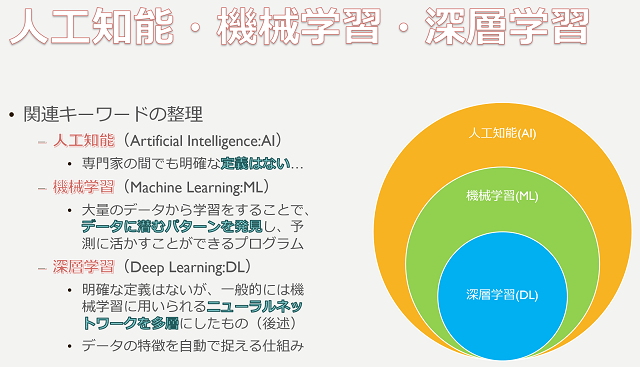

機械学習には、この「教師あり学習」以外にも、「教師なし学習」や「強化学習」という手法が存在します。

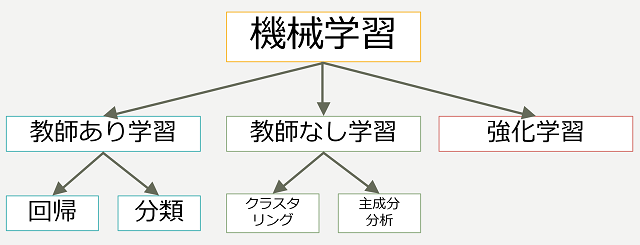

次のノートブックでは、機械学習の「教師なし学習」の中の「クラスタリング」や「主成分分析」のタスクに挑戦してみましょう。